In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
input_length = 336
output_length = 168

show_graph = True

In [3]:
model_paths = ["Save_File/Group3_1/A1.ckpt"]

building_num = [4]

# model_paths = ["Save_File/experiment/4/4.ckpt",
#                "Save_File/experiment/4/401.ckpt",
#                "Save_File/experiment/4/402.ckpt",
#                "Save_File/experiment/4/403.ckpt",
#                "Save_File/experiment/4/404.ckpt",
#                "Save_File/experiment/4/405.ckpt",
#                "Save_File/experiment/4/406.ckpt",
#                "Save_File/experiment/4/407.ckpt"]

# model_paths = ["Save_File/experiment/4/41.ckpt",
#                "Save_File/experiment/4/42.ckpt",
#                "Save_File/experiment/4/43.ckpt",
#                "Save_File/experiment/4/44.ckpt",
#                "Save_File/experiment/4/45.ckpt",
#                "Save_File/experiment/4/46.ckpt",
#                "Save_File/experiment/4/47.ckpt",
#                "Save_File/experiment/4/48.ckpt",
#                "Save_File/experiment/4/49.ckpt",
#                "Save_File/experiment/4/401.ckpt"]

# building_num = [4 for i in range(12)]


# model_paths = ["Save_File/experiment/4/4.ckpt",
#                "Save_File/experiment/4/401.ckpt",
#                "Save_File/experiment/4/402.ckpt",
#                "Save_File/experiment/4/403.ckpt",
#                "Save_File/experiment/4/404.ckpt",
#                "Save_File/experiment/4/405.ckpt",
#                "Save_File/experiment/4/406.ckpt",
#                "Save_File/experiment/4/407.ckpt",
#                "Save_File/experiment/4/408.ckpt",
#                "Save_File/experiment/4/409.ckpt"]

# building_num = [4 for i in range(12)]
# building_num = [36 for i in range(12)]
# building_num = [60 for i in range(12)]

data_path = "./Refined_Data/Grouped_Data/Input_Data2.csv"

In [4]:
dataframes = pd.read_csv(data_path, parse_dates = ["date_time"])

dataframes['num']     =   dataframes['num'].apply(str)
dataframes['day_of_Week']     =   dataframes['day_of_Week'].apply(str)
dataframes['day_of_month']    =   dataframes['day_of_month'].apply(str)
dataframes['24Hour']  =   dataframes['24Hour'].apply(str)
dataframes['holiday'] =   dataframes['holiday'].apply(str)
dataframes['Weekend'] =   dataframes['Weekend'].apply(str)
dataframes['energy_group'] = dataframes['energy_group'].apply(str)
dataframes['hour_cat']=   dataframes['hour_cat'].apply(str)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + 1e-10))

all_smape = [[] for i in range(len(model_paths))]
step_smape = [[] for i in range(2, 13)]
step_mean_smape = []

selected time slice : 3
4


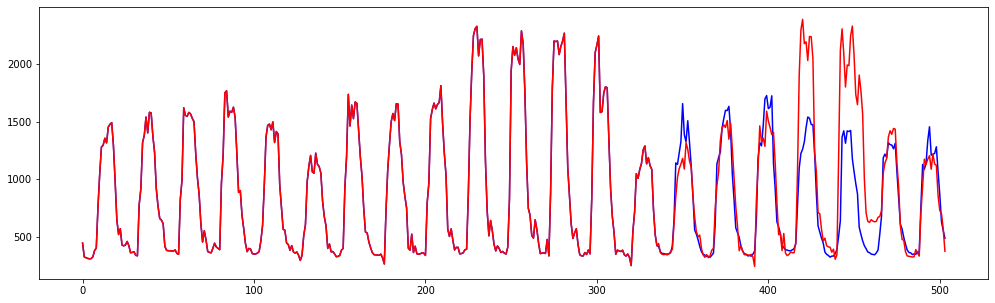

building : Save_File/Group3_1/A1.ckpt, score : 10.191078373466693
this slice : 3, score : 10.191078373466693
selected time slice : 4
4


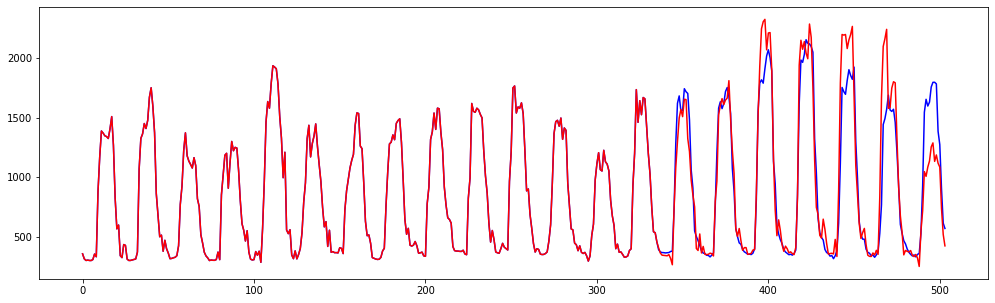

building : Save_File/Group3_1/A1.ckpt, score : 6.695310614957713
this slice : 4, score : 6.695310614957713
selected time slice : 5
4


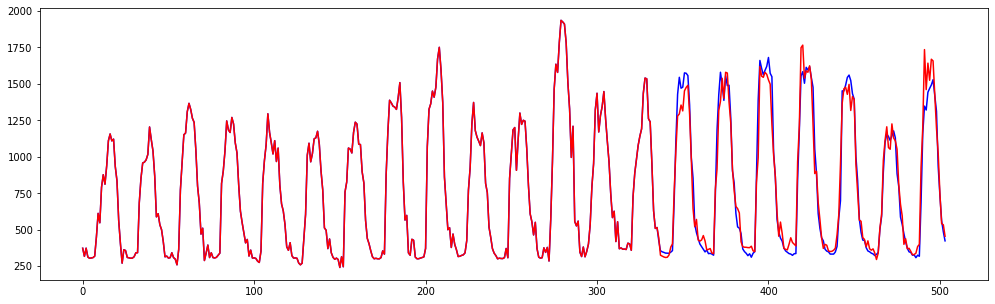

building : Save_File/Group3_1/A1.ckpt, score : 4.249025014816958
this slice : 5, score : 4.249025014816958
selected time slice : 6
4


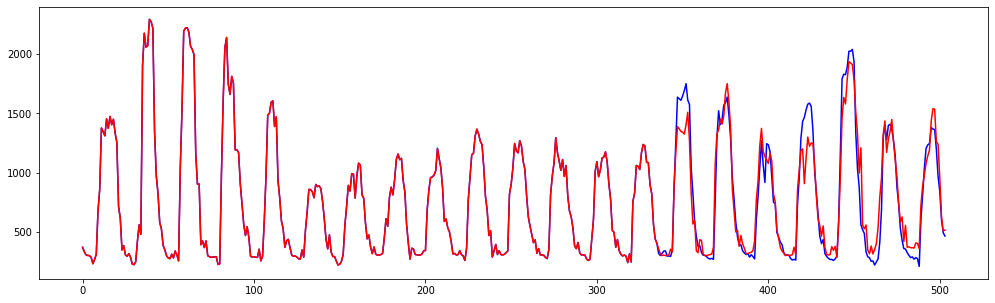

building : Save_File/Group3_1/A1.ckpt, score : 7.547853315369138
this slice : 6, score : 7.547853315369138
selected time slice : 7
4


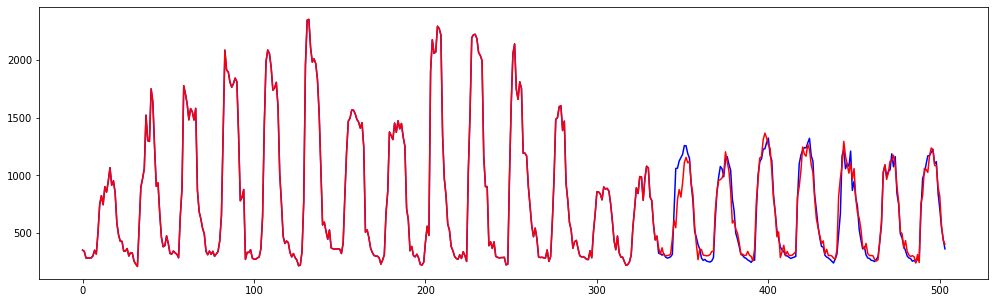

building : Save_File/Group3_1/A1.ckpt, score : 5.16281670408703
this slice : 7, score : 5.16281670408703
selected time slice : 8
4


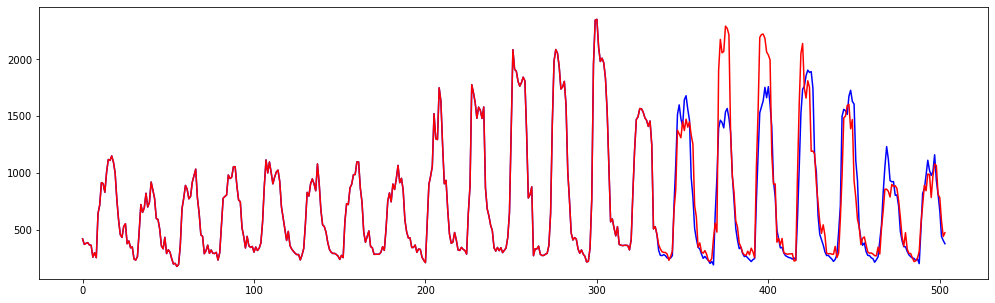

building : Save_File/Group3_1/A1.ckpt, score : 8.67072808273292
this slice : 8, score : 8.67072808273292
selected time slice : 9
4


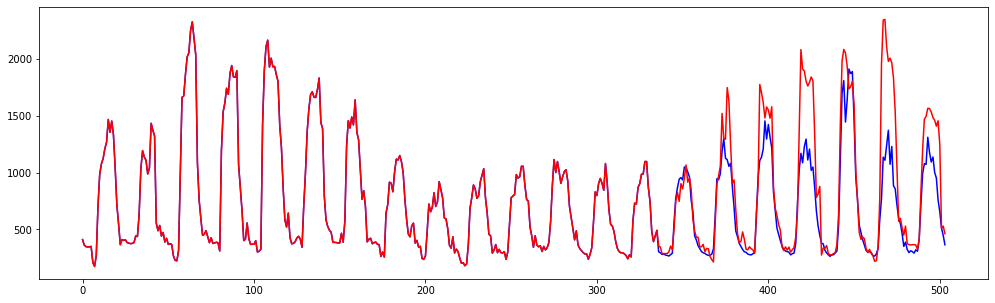

building : Save_File/Group3_1/A1.ckpt, score : 9.901689188339743
this slice : 9, score : 9.901689188339743
selected time slice : 10
4


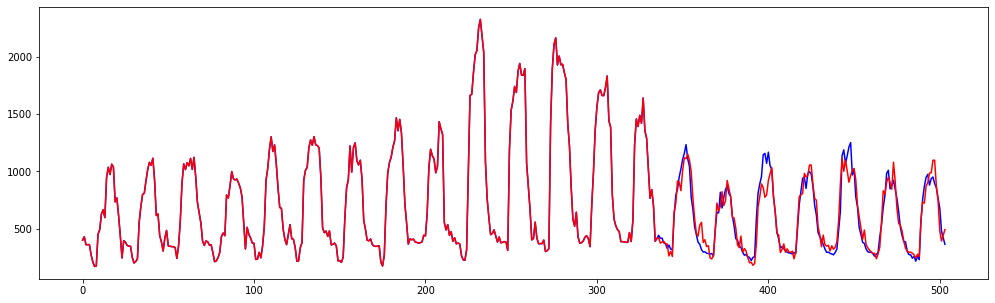

building : Save_File/Group3_1/A1.ckpt, score : 6.009569624425646
this slice : 10, score : 6.009569624425646
selected time slice : 11
4


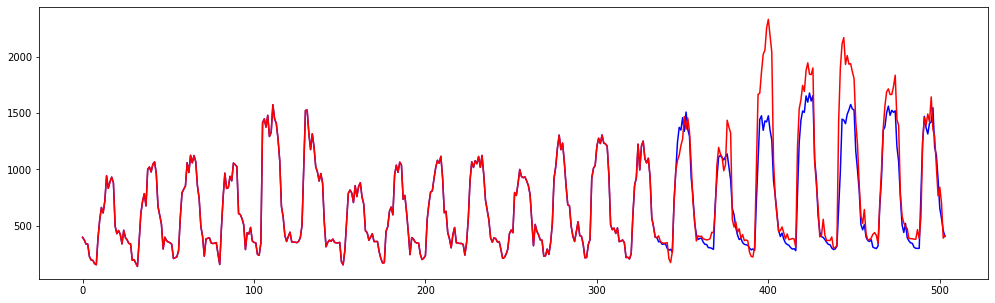

building : Save_File/Group3_1/A1.ckpt, score : 8.13599538105587
this slice : 11, score : 8.13599538105587


In [5]:
for random_choice in range(3, 12):

    print(f"selected time slice : {random_choice}")
    start_point = -168 * random_choice - 1
    duration = 168

    for i in range(len(model_paths)):

        now_building_dataframe = dataframes.loc[dataframes["num"] == str(building_num[i])].copy()
        now_building_dataframe = now_building_dataframe[start_point:start_point+input_length+duration]
        
        now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

        original = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()  

        total_cycle = ((len(now_building_dataframe) - input_length - output_length) // output_length) + 1

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
            originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

            prediction.extend(raw_predictions)
            original.extend(originals)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        if show_graph:
            plt.rcParams["figure.figsize"] = (17,5)
            fig = plt.figure()
            graph = fig.add_subplot(1, 1, 1)
            graph.plot(prediction, color='blue')
            graph.plot(original, color='red')
            plt.show()

        smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
        print(f"building : {model_paths[i]}, score : {smape_loss}")
        all_smape[i].append(smape_loss)
        step_smape[random_choice-2].append(smape_loss)
    print(f"this slice : {random_choice}, score : {np.mean(np.array(step_smape[random_choice-2]))}")
    step_mean_smape.append(np.mean(np.array(step_smape[random_choice-2])))

In [6]:
print(f"total score mean : {np.mean(np.array(step_mean_smape))}")
for i in range(len(all_smape)):
    print(f"index : {i}, totoal score : {np.mean(np.array(all_smape[i]))}, min : {np.min(np.array(all_smape[i]))}, max : {np.max(np.array(all_smape[i]))}")

total score mean : 7.396007366583524
index : 0, totoal score : 7.396007366583524, min : 4.249025014816958, max : 10.191078373466693
